In [1]:
import pandas as pd
import osmnx as ox
import config
import peartree as pt
import partridge as ptg
import networkx as nx
import testing.helpers.testing_helper as helper

In [2]:
feed = ptg.load_feed(f"{config.testing_data_path}/"
                     f"google_transit_locallink.zip")

In [ ]:
# feed = pt.get_representative_feed(f"{config.testing_data_path}/"
#                                   f"google_transit_locallink.zip")
# len(feed.stops)

In [3]:
# filter the feed so to only include bus stops with a latitude greater
# than the minimum latitude value from the population data
# population_data = pd.read_csv(config.population_csv)
# min_lat = population_data.lat.min()
# min_lat

54.4688255

In [4]:
# filtered_stops = feed.stops[feed.stops.stop_lat >= min_lat]
# len(filtered_stops)

164

In [5]:
# find stops with "Derry" in their name.
# filtered_stops[filtered_stops["stop_name"].str.contains("Derry")]

,stop_id,stop_name,stop_lat,stop_lon
0,7000B158241,Derry (Magee Campus Strand Road),55.004476,-7.321782
656,853000095,Molloys Supermarket Derrybeg,55.078139,-8.289987
784,gen:31400:890:0:1,"Derry, Water Street",54.996069,-7.317329
875,gen:57402:8160:0:1,"Derrycassan Cottages, Simons",55.203874,-7.849413
876,gen:57402:8161:0:1,"Derrycassan, Grotto",55.210575,-7.856003


In [6]:
# remove the Derry stops
# ids_to_exclude = ["7000B158241", "gen:31400:890:0:1"]
# filtered_stops = filtered_stops[~filtered_stops["stop_id"].isin(ids_to_exclude)]

In [28]:
# get donegal records from stop_times to find the path followed
# filtered_stop_times = feed.stop_times[
#     feed.stop_times.stop_id.isin(
#         filtered_stops["stop_id"])]

In [3]:
# get donegal routes, agency_id="LLDL"
filtered_routes = feed.routes[feed.routes.agency_id == "LLDL"]
filtered_routes

,route_id,agency_id,route_short_name,route_long_name,route_type
7,49-244-y11-2,LLDL,244,NaN,3
12,49-271-y11-2,LLDL,271,NaN,3
17,49-288-y11-1,LLDL,288,NaN,3
18,49-290-y11-1,LLDL,290,NaN,3
19,49-292-y11-2,LLDL,292,NaN,3
20,49-293-y11-1,LLDL,293,NaN,3
21,49-300-y11-4,LLDL,300,NaN,3
37,49-564-y11-2,LLDL,564,NaN,3
38,49-568-y11-1,LLDL,568,NaN,3
41,49-572-y11-1,LLDL,572,NaN,3


In [4]:
# route ids
donegal_routes = filtered_routes.route_id.to_list()
donegal_routes

['49-244-y11-2',
 '49-271-y11-2',
 '49-288-y11-1',
 '49-290-y11-1',
 '49-292-y11-2',
 '49-293-y11-1',
 '49-300-y11-4',
 '49-564-y11-2',
 '49-568-y11-1',
 '49-572-y11-1',
 '49-953-y11-1',
 '49-954-y11-1',
 '49-955-y11-2',
 '49-966-y11-1',
 '49-967-y11-1',
 '49-977-y11-1',
 '49-982-y11-5',
 '49-983-y11-3',
 '49-987-y11-2',
 '49-989-y11-1',
 '49-992-y11-1',
 '49-993-y11-1',
 '49-994-y11-1']

In [43]:
# ###################
# a = filtered_stop_times["trip_id"].str.contains("49-568-y11-1")
# b = a[a.values == True]

In [5]:
# use the route ids to find matches in filtered stop times,
# add route_id column and find unique stop time records
stop_times = feed.stop_times
for route in donegal_routes:
    stop_times.loc[
        stop_times["trip_id"].str.contains(route), "route_id"] = route
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id
0,1.Mo-Fr.49-115-D-y11-1.1.O,25800.0,25800.0,8310B1328702,1,NaN,0,0,0.00,NaN
1,1.Mo-Fr.49-115-D-y11-1.1.O,26700.0,26700.0,831000122,2,NaN,0,0,6779.94,NaN
2,1.Mo-Fr.49-115-D-y11-1.1.O,27300.0,27300.0,8310B1320302,3,NaN,0,0,13637.85,NaN
3,1.Mo-Fr.49-115-D-y11-1.1.O,27900.0,27900.0,8310B1031301,4,NaN,0,0,20286.49,NaN
4,1.Mo-Fr.49-115-D-y11-1.1.O,28800.0,28800.0,8310B1358801,5,NaN,0,0,29956.82,NaN
...,...,...,...,...,...,...,...,...,...,...
10413,16.Sat.49-M2-y11-4.28.I,70200.0,70200.0,8540B1559201,1,NaN,0,0,0.00,NaN
10414,16.Sat.49-M2-y11-4.28.I,70500.0,70500.0,8540LL10200,2,NaN,0,0,884.54,NaN
10415,16.Sat.49-M2-y11-4.28.I,70860.0,70860.0,8540LL10195,3,NaN,0,0,2349.81,NaN
10416,16.Sat.49-M2-y11-4.28.I,71160.0,71160.0,8540LL10194,4,NaN,0,0,7986.03,NaN


In [6]:
# keep only route, stop and sequence columns and drop duplicate rows
routes = stop_times[["trip_id", "route_id", "stop_id", "stop_sequence"]]
# stop_times[stop_times.route_id == "49-568-y11-1"]
routes

,trip_id,route_id,stop_id,stop_sequence
0,1.Mo-Fr.49-115-D-y11-1.1.O,NaN,8310B1328702,1
1,1.Mo-Fr.49-115-D-y11-1.1.O,NaN,831000122,2
2,1.Mo-Fr.49-115-D-y11-1.1.O,NaN,8310B1320302,3
3,1.Mo-Fr.49-115-D-y11-1.1.O,NaN,8310B1031301,4
4,1.Mo-Fr.49-115-D-y11-1.1.O,NaN,8310B1358801,5
...,...,...,...,...
10413,16.Sat.49-M2-y11-4.28.I,NaN,8540B1559201,1
10414,16.Sat.49-M2-y11-4.28.I,NaN,8540LL10200,2
10415,16.Sat.49-M2-y11-4.28.I,NaN,8540LL10195,3
10416,16.Sat.49-M2-y11-4.28.I,NaN,8540LL10194,4


In [7]:
# find stops with "Derry" in their name.
feed.stops[feed.stops["stop_name"].str.contains("Derry")]

,stop_id,stop_name,stop_lat,stop_lon
0,7000B158241,Derry (Magee Campus Strand Road),55.004476,-7.321782
136,828000281,"Irishtown (Laois), Derrycappagh House",53.111947,-7.325835
502,848000018,Derryoughter,53.920913,-7.991871
613,852000094,"Derrycramph, Drumglen Drive",53.986386,-7.380056
656,853000095,Molloys Supermarket Derrybeg,55.078139,-8.289987
784,gen:31400:890:0:1,"Derry, Water Street",54.996069,-7.317329
875,gen:57402:8160:0:1,"Derrycassan Cottages, Simons",55.203874,-7.849413
876,gen:57402:8161:0:1,"Derrycassan, Grotto",55.210575,-7.856003


In [8]:
# remove the Derry stops from route times
ids_to_exclude = ["7000B158241", "gen:31400:890:0:1"]
routes = routes[~stop_times["stop_id"].isin(ids_to_exclude)]
len(routes)

10415

In [8]:
# routes = routes.drop_duplicates()
# len(routes)

1872

In [48]:
route_dict = {route: routes.loc[routes["route_id"] == route] for route in donegal_routes}
route_dict

{'49-244-y11-2':                        trip_id      route_id    stop_id  stop_sequence
 1813  1.Mo-Fr.49-244-y11-2.1.O  49-244-y11-2  853000121              2
 1814  1.Mo-Fr.49-244-y11-2.1.O  49-244-y11-2  853000059              3,
 '49-271-y11-2':                        trip_id      route_id          stop_id  stop_sequence
 2224  3.Mo-Sa.49-271-y11-2.4.I  49-271-y11-2        853000331              1
 2225  3.Mo-Sa.49-271-y11-2.4.I  49-271-y11-2  gen:57402:1:0:1              2
 2226  3.Mo-Sa.49-271-y11-2.4.I  49-271-y11-2        853000270              3
 2227  3.Mo-Sa.49-271-y11-2.4.I  49-271-y11-2        853000273              4
 2228  3.Mo-Sa.49-271-y11-2.4.I  49-271-y11-2        853000054              5
 ...                        ...           ...              ...            ...
 2337  5.Mo-Sa.49-271-y11-2.1.O  49-271-y11-2        853000053              5
 2338  5.Mo-Sa.49-271-y11-2.1.O  49-271-y11-2        853000273              6
 2339  5.Mo-Sa.49-271-y11-2.1.O  49-271-y11-2    

In [49]:
for route in donegal_routes:
    route_dict[route] = helper.get_path_of_route(route_dict[route])

In [50]:
# combine dictionary items into a single dataframe
df_list = [ v for k,v in route_dict.items()]
routes_df = pd.concat(df_list ,axis=0)
routes_df
# a = [x["stop_id"] for x in route_dict.items()]

,route_id,stop_id,stop_sequence
1813,49-244-y11-2,853000121,2
1814,49-244-y11-2,853000059,3
2224,49-271-y11-2,853000331,1
2225,49-271-y11-2,gen:57402:1:0:1,2
2226,49-271-y11-2,853000270,3
...,...,...,...
8731,49-994-y11-1,853000111,5
8732,49-994-y11-1,gen:57402:8049:0:1,6
8733,49-994-y11-1,gen:57402:8050:0:1,7
8734,49-994-y11-1,8530B141111,8


In [51]:
# add route indicator to stop_sequence, to differentiate stops on multiple routes
i = 1
for route in donegal_routes:
    routes_df.loc[
        routes_df["route_id"] == route, "route_number"] = f"{i}"
    i += 1
routes_df

,route_id,stop_id,stop_sequence,route_number
1813,49-244-y11-2,853000121,2,1
1814,49-244-y11-2,853000059,3,1
2224,49-271-y11-2,853000331,1,2
2225,49-271-y11-2,gen:57402:1:0:1,2,2
2226,49-271-y11-2,853000270,3,2
...,...,...,...,...
8731,49-994-y11-1,853000111,5,23
8732,49-994-y11-1,gen:57402:8049:0:1,6,23
8733,49-994-y11-1,gen:57402:8050:0:1,7,23
8734,49-994-y11-1,8530B141111,8,23


In [52]:
# drop route_id
routes_df = routes_df.drop(["route_id"], axis=1)
routes_df


,stop_id,stop_sequence,route_number
1813,853000121,2,1
1814,853000059,3,1
2224,853000331,1,2
2225,gen:57402:1:0:1,2,2
2226,853000270,3,2
...,...,...,...
8731,853000111,5,23
8732,gen:57402:8049:0:1,6,23
8733,gen:57402:8050:0:1,7,23
8734,8530B141111,8,23


In [53]:
# get stop co-ordinates
# find unique stop_ids
stops = routes_df["stop_id"].unique().tolist()

for stop in stops:
    stop_feed = feed.stops[feed.stops.stop_id == stop]
    routes_df.loc[
        routes_df["stop_id"] == stop,
        "lat"] = stop_feed.stop_lat.values[0]
    routes_df.loc[
        routes_df["stop_id"] == stop,
        "lng"] = stop_feed.stop_lon.values[0]
routes_df

,stop_id,stop_sequence,route_number,lat,lng
1813,853000121,2,1,55.251280,-7.261468
1814,853000059,3,1,55.189020,-7.039784
2224,853000331,1,2,54.954142,-7.728641
2225,gen:57402:1:0:1,2,2,54.961286,-7.862579
2226,853000270,3,2,54.985302,-7.889948
...,...,...,...,...,...
8731,853000111,5,23,54.761981,-8.413545
8732,gen:57402:8049:0:1,6,23,54.745630,-8.356223
8733,gen:57402:8050:0:1,7,23,54.713016,-8.310079
8734,8530B141111,8,23,54.653856,-8.285826


In [54]:
# number of stops
len(routes_df["stop_id"].unique())

184

In [55]:
len(routes_df)

209

In [58]:
# load graph so that locallink bus routes can be added
G = ox.load_graphml(filepath=f"{config.rp_graphml_path}/all_routes.graphml")
# add node attribute for each actual route
for i in range(1, 24):
    nx.set_node_attributes(G, None, f"actual_route_{i}")

for index, row in routes_df.iterrows():
    nearest_node = ox.get_nearest_node(G, (row["lat"], row["lng"]))
    # comma separate route values
    G.nodes[nearest_node][f"actual_route_{row['route_number']}"] = row["stop_sequence"]
    i += 1

In [59]:
nodes = ox.graph_to_gdfs(G, edges=False)
nodes

,y,x,osmid,community,rank,geometry,top_n,route_flag,community_route,community_route_order,...,actual_route_15,actual_route_16,actual_route_17,actual_route_18,actual_route_19,actual_route_20,actual_route_21,actual_route_22,actual_route_23,highway
2114650326,55.057663,-7.403884,2114650326,0,0.0002304475544637878,POINT (-7.40388 55.05766),0,0,False,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2114650363,55.058671,-7.401458,2114650363,0,0.0005012166713618143,POINT (-7.40146 55.05867),14,0,True,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2114650574,55.065282,-7.431412,2114650574,0,0.00039074531890811445,POINT (-7.43141 55.06528),0,0,True,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2114650603,55.056001,-7.403478,2114650603,0,0.0002147939880001362,POINT (-7.40348 55.05600),0,0,False,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258442518,55.132364,-7.454354,258442518,0,0.00020807192473270327,POINT (-7.45435 55.13236),0,0,False,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895464217,55.022280,-8.301011,1895464217,9,0.00020824925797252749,POINT (-8.30101 55.02228),0,0,True,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1878490428,54.931667,-8.419818,1878490428,9,0.00028288951702548035,POINT (-8.41982 54.93167),0,0,False,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1878490444,54.929254,-8.441124,1878490444,9,0.00028813735045901657,POINT (-8.44112 54.92925),0,0,False,-1,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1895464579,55.022001,-8.320247,1895464579,9,0.0001534778486489186,POINT (-8.32025 55.02200),0,0,False,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# check that comma separation worked
nodes[nodes["test_route"].str.contains(",")]

,y,x,osmid,community,rank,geometry,top_n,route_flag,community_route,community_route_order,connection,connection_order,test_stop,test_route,highway
1924390314,55.189202,-7.038989,1924390314,1,0.0002614244613985181,POINT (-7.03899 55.18920),0,0,False,88,None,-1,True,"LL1-3,LL11-1",NaN
843310079,55.251139,-7.261558,843310079,1,0.00027770146572002173,POINT (-7.26156 55.25114),0,0,False,-1,None,-1,True,"LL1-2,LL12-1,LL13-1",NaN
1922602861,54.951725,-7.724164,1922602861,10,0.00020539054971560543,POINT (-7.72416 54.95173),0,0,False,-1,None,-1,True,"LL4-3,LL11-6,LL19-1",NaN
791492626,54.953794,-7.728927,791492626,10,0.0002868546901584306,POINT (-7.72893 54.95379),0,0,False,88,None,-1,True,"LL2-1,LL7-1,LL11-7,LL20-6",NaN
529604600,54.951158,-7.428390,529604600,15,4.7061908615644145e-05,POINT (-7.42839 54.95116),0,0,False,-1,None,-1,True,"LL3-2,LL20-1",NaN
1931036767,54.934688,-7.460495,1931036767,15,0.00020382621836313153,POINT (-7.46050 54.93469),0,0,False,52,None,-1,True,"LL3-3,LL20-2",NaN
33217751,54.831812,-7.483017,33217751,15,0.0003164699029820009,POINT (-7.48302 54.83181),0,0,False,-1,None,-1,True,"LL3-6,LL19-2",NaN
1330141782,54.800150,-7.778523,1330141782,2,0.000230678263863786,POINT (-7.77852 54.80015),0,0,False,-1,None,3,True,"LL3-12,LL4-9",NaN
33217639,54.801068,-7.642184,33217639,2,0.0004084586754803834,POINT (-7.64218 54.80107),0,0,True,24,d,34,True,"LL3-9,LL4-6",NaN
794919787,55.177628,-7.793545,794919787,3,0.0005565430216973197,POINT (-7.79354 55.17763),0,0,True,18,None,-1,True,"LL22-1,LL22-13",NaN


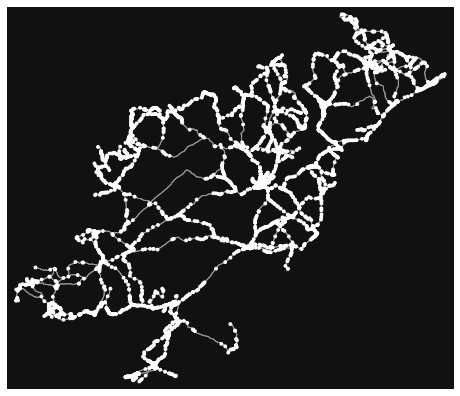

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f001aeb94f0>)

In [60]:
ox.plot_graph(G)

In [61]:
ox.save_graphml(G, filepath=f"{config.testing_graphml_path}/actual_routes_added.graphml")


In [ ]:
# find maximum stop sequence value
max_number_stops = route1["stop_sequence"].max()
max_number_stops

In [19]:
# filter to only include one sequence,
# get trip_id of first occurance of stops max
trip_id = route1[route1["stop_sequence"] == max_number_stops]["trip_id"].values[0]
trip_id

'3.Mo-Sa.49-271-y11-2.4.I'

In [21]:
# exclude any records that don't have that trip_id
route1 = route1[route1["trip_id"] == trip_id]
route1




,trip_id,route_id,stop_id,stop_sequence
2224,3.Mo-Sa.49-271-y11-2.4.I,49-271-y11-2,853000331,1
2225,3.Mo-Sa.49-271-y11-2.4.I,49-271-y11-2,gen:57402:1:0:1,2
2226,3.Mo-Sa.49-271-y11-2.4.I,49-271-y11-2,853000270,3
2227,3.Mo-Sa.49-271-y11-2.4.I,49-271-y11-2,853000273,4
2228,3.Mo-Sa.49-271-y11-2.4.I,49-271-y11-2,853000054,5
2229,3.Mo-Sa.49-271-y11-2.4.I,49-271-y11-2,853000118,6
2230,3.Mo-Sa.49-271-y11-2.4.I,49-271-y11-2,8530PB000430,7
2231,3.Mo-Sa.49-271-y11-2.4.I,49-271-y11-2,853000155,8
2232,3.Mo-Sa.49-271-y11-2.4.I,49-271-y11-2,gen:57402:8056:0:1,9


In [ ]:
######################################
feed.set("stops.txt", filtered_stops)
len(feed.stops)

In [9]:
start = 1
end = 86400
%time G = pt.load_feed_as_graph(feed, start, end)

/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/peartree/parallel.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  direction_subset = stop_times_by_stop[constraint_2]


CPU times: user 5.79 s, sys: 11.5 ms, total: 5.8 s
Wall time: 5.84 s


/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3703dd9610>)

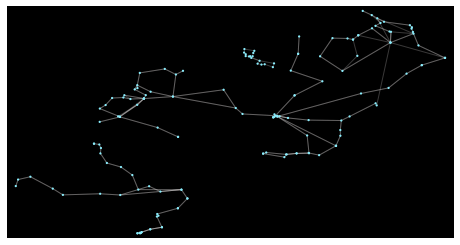

In [10]:
import matplotlib as mpl

ox.plot_graph(G,
              show=False,
              close=False,
              node_color='#8aedfc',
              node_size=5,
              edge_color='#e2dede',
              edge_alpha=0.25,
              bgcolor='black')

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# We need a coverage area, based on the points from the
# New Orleans GTFS data, which we can pull from the peartree
# network graph by utilizing coordinate values and extracting
# a convex hull from the point cloud
boundary = gpd.GeoSeries(
    [Point(n['x'], n['y']) for i, n in G.nodes(data=True)]
    ).unary_union.convex_hull

# Visually inspect
boundary

In [ ]:
%time
G_all_routes = ox.load_graphml(filepath=f"{config.rp_graphml_path}/all_routes.graphml")
# Gdrive = ox.graph_from_polygon(boundary, network_type='drive')

In [ ]:
ox.plot_graph(G_all_routes)

In [ ]:
%time G2 = pt.load_feed_as_graph(feed, start, end, existing_graph=G_all_routes)

In [ ]:
# nodes, edges = ox.graph_to_gdfs(G2)
ox.plot_graph(G2)

In [ ]:
n = nx.get_node_attributes(G2, "modes")

In [ ]:
nodes = G2.nodes(data=True)
edges = G2.edges(data=True)

In [ ]:
nodes['OJ097_gen:57402:8224:0:1']

In [32]:
###########################
# load population dataset, need to check min value
# for latitude columns
population_data = pd.read_csv(config.population_csv)
min_lat = population_data["lat"].min()

In [4]:
# load locallinks stop data.
# filter to only include stops within range of latitude/longitude
locallink_stops = pd.read_csv(f"{config.locallink_data_path}/stops.txt")
locallink_stops.head()

,stop_id,stop_name,stop_lat,stop_lon
0,7000B158241,Derry (Magee Campus Strand Road) 1,55.004476,-7.321782
1,821000001,Green Lane 1,52.841907,-6.916965
2,821000002,Green Lane 2,52.841728,-6.916984
3,8210B3355701,"Carlow, Carlow Coach Park ->SW2",52.833629,-6.926847
4,8210B351711,Lucy Nolan's 1,52.740188,-6.770400


In [5]:
donegal_stops = locallink_stops[(locallink_stops["stop_lat"] >= min_lat)]
pd.set_option('display.max_rows', 15)
donegal_stops
# there are unexpected stops returned. e.g Derry, Magee Campus
# cross check stops with stop times data

,stop_id,stop_name,stop_lat,stop_lon
0,7000B158241,Derry (Magee Campus Strand Road) 1,55.004476,-7.321782
630,853000002,Portsalon 2,55.205555,-7.636540
631,853000004,"Arryheernabin, Fanad Lighthouse 1",55.276113,-7.632418
632,853000007,Falcarragh 1,55.136505,-8.104273
633,853000009,Fintown 1,54.868210,-8.124345
...,...,...,...,...
868,gen:57402:8177:0:1,"Buncrana, Buncrana 1",55.136192,-7.456586
869,gen:57402:8178:0:1,"Tir Na Sligo, Tiernasligo National School 1",55.269323,-7.497034
870,gen:57402:8179:0:1,"Straid (Donegal), Waterfall 1",55.267925,-7.436002
871,gen:57402:8224:0:1,"Bridge End, 19th Hole Bar 1",55.044388,-7.381098


In [6]:
len(donegal_stops)

162

In [7]:
# save to csv for manual removal of stops not in Donegal
donegal_stops.to_csv(f"{config.locallink_data_path}/donegal_stops_for_manual_review.csv")

In [9]:
# removed derry stops
updated_donegal_stops = pd.read_csv(f"{config.locallink_data_path}/donegal_stops_updated.csv")
len(updated_donegal_stops)
# ready to find closest nodes on road network graph to add LL labels

160